In [1]:
# Import modules
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from minisom import MiniSom
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve

In [2]:
# Import dataset
data_dos = pd.read_csv("/users/mik2002/dataset/processed_friday_dataset.csv")
data_brute = pd.read_csv("/users/mik2002/som/dataset-processed/processed_wednesday1_dataset.csv")

In [3]:
df_dataset = pd.concat([data_dos, data_brute], axis=0, ignore_index=True)

In [4]:
df_dataset.shape

(2185101, 73)

In [5]:
df_dataset["Label"].value_counts()

Label
0             1074342
Benign         664002
1              290089
Bruteforce     156668
Name: count, dtype: int64

In [6]:
df_dataset.replace(to_replace=["Benign"], value=0, inplace=True)


In [7]:
df_dataset.replace(to_replace=["Bruteforce"], value=2, inplace=True)

/tmp/ipykernel_166016/3740490766.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dataset.replace(to_replace=["Bruteforce"], value=2, inplace=True)


In [8]:
df_dataset["Label"].value_counts()

Label
0    1738344
1     290089
2     156668
Name: count, dtype: int64

In [9]:
columns_to_drop = [
'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg','CWE Flag Count','Bwd Blk Rate Avg'
]

In [10]:
df_dataset.drop(columns=columns_to_drop, inplace=True)
df_dataset.shape

(2185101, 66)

In [11]:
df_shuffled = df_dataset.sample(frac=1).reset_index(drop=True)

In [12]:
# split dataset in data and target 
target = df_shuffled.iloc[:len(df_dataset),-1].values
data = df_shuffled.iloc[:len(df_dataset),:-1]

In [13]:
prova = target.tolist()
set(prova)

{0, 1, 2}

In [14]:
count_labels = {i:prova.count(i) for i in set(prova)}
# Calculate the number of Benign and Malicious labels.
benign_count = count_labels.get(0, 0)
dos_count = count_labels.get(1, 0)
bforce_count = count_labels.get(2, 0)

# Calculate percentages
total_count = benign_count + dos_count + bforce_count
benign_percent = (benign_count / total_count) * 100
dos_percent = (dos_count / total_count) * 100
bforce_percent = (bforce_count / total_count) * 100

# Print the percentages
print(f"Percentage of Benign labels: {benign_percent:.2f}%")
print(f"Percentage of DOS labels: {dos_percent:.2f}%")
print(f"Percentage of Brute Force labels: {bforce_percent:.2f}%")

Percentage of Benign labels: 79.55%
Percentage of DOS labels: 13.28%
Percentage of Brute Force labels: 7.17%


In [15]:
# normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [16]:
# split data in Training and Testing set
X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.5)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing  set has {} samples.".format(X_test.shape[0]))

Training set has 1092550 samples.
Testing  set has 1092551 samples.


In [17]:
# since this in supervised classification not unsupervised, this function chooses the class of
# the BMU to be the final class of each instance
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [18]:
# set hyperparameters
n_neurons = 60
m_neurons = 60
input_len = X_train.shape[1]
sigma = 1.5
learning_rate = 1.2
iterations = X_train.shape[0]

In [19]:
from minisom import MiniSom
# initialization
som = MiniSom(x=n_neurons, y=m_neurons,input_len=input_len,sigma=sigma,learning_rate=learning_rate)
som.random_weights_init(X_train)

In [20]:
%%time
som.train(X_train, iterations, verbose=True)  # random training

 [     102 / 1092550 ]   0% - 0:35:40 left 

 [ 1092550 / 1092550 ] 100% - 0:00:00 left 

/users/mik2002/.local/lib/python3.10/site-packages/minisom.py:540: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



 quantization error: 0.0069325310696447895
CPU times: user 41min 1s, sys: 1min 21s, total: 42min 23s
Wall time: 37min 35s


In [21]:
%%time
y_pred = classify(som, X_test)
report = classification_report(y_test, y_pred, digits=4)
print(report)

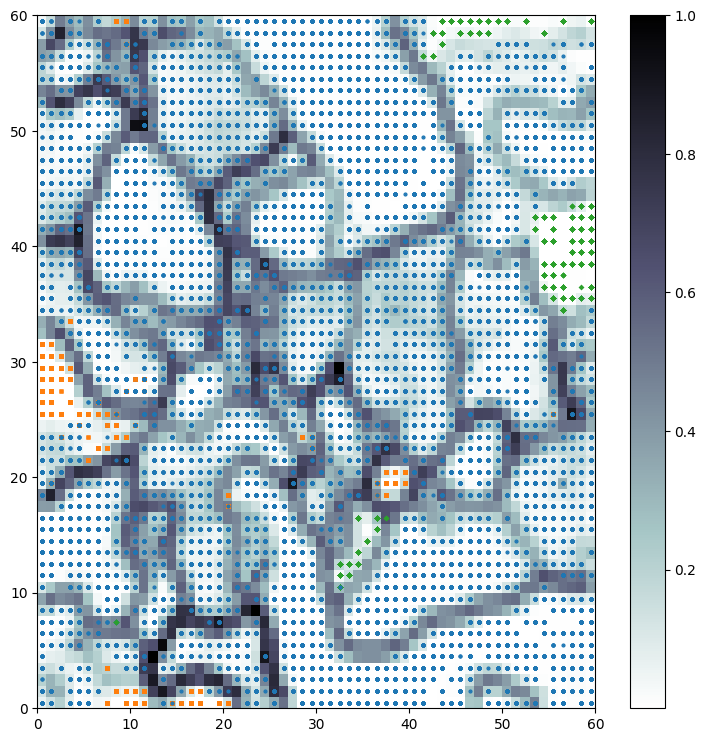

CPU times: user 1h 5min 18s, sys: 1min 21s, total: 1h 6min 39s
Wall time: 1h 6min 34s


In [ ]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the processed_friday_dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['g', 'C1', 'm']

for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor=colors[target[cnt]],
             markeredgecolor=colors[target[cnt]], markersize=1, markeredgewidth=2)


plt.show()